In [25]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.pyplot as plt

t.set_printoptions(precision=2, sci_mode=False)

In [2]:
def plot_predictions_vs_train(predictions, train_data, title="Predictions vs Training Data", xlabel="Training Data", ylabel="Predictions"):
    # Ensure predictions and train_data are numpy arrays for compatibility with matplotlib
    if isinstance(predictions, t.Tensor):
        predictions = predictions.detach().cpu().numpy()

    if isinstance(train_data, t.Tensor):
        train_data = train_data.detach().cpu().numpy()

    plt.figure(figsize=(10, 6))

    # Scatter plot of training data
    plt.scatter(train_data, predictions, label='Data Points', alpha=0.5, color='blue')

    # Optional: plot a line of best fit
    # You can uncomment the next two lines to plot the line of best fit for the scatter plot
    m, b = np.polyfit(train_data.flatten(), predictions.flatten(), 1)
    plt.plot(train_data, m*train_data + b, color='red')

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

In [386]:
class MLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim, scale=.1 ):
        super(MLPLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, min(input_dim,output_dim))
        self.fc2 = nn.Linear(min(input_dim,output_dim), output_dim)
        # self.initialize_weights(scale)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    def initialize_weights(self, scale):
        # Initialize weights with scaled He initialization
        nn.init.kaiming_normal_(self.fc1.weight, a=0, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, a=0, mode='fan_in', nonlinearity='relu')

        # Scaling the weights
        self.fc1.weight.data *= scale
        self.fc2.weight.data *= scale


In [468]:
import torch as t
import torch.nn as nn
import itertools
import math

class CorrLoss(nn.Module):
    def __init__(self, rank=None):
        super(CorrLoss, self).__init__()
        self.rank = rank  # Rank for truncated SVD

    def forward(self, activations):        
        # activations is [batch, seq, heads, d_model]
        assert activations.dim() == 4, "activations must be [batch, seq, heads, d_model]"

        # flatten the list of lists of matrices ( seq * rank matrices )
        m_list = list(itertools.chain.from_iterable(self.all_tensors(activations)))

        loss = t.stack( m_list ).abs().sum()

        # loss += self.corr( activations.reshape( -1 , activations.shape[-1] ) ).abs().sum()

        return loss
        
    # returned data is [batch, head_idx, rank]
    def feature_reduction(self, data):
        #  data is [batch, seq=1, heads , d_model]
        assert data.dim() == 3, "data must be [batch, heads, d_model] (e.g. sliced by seq)"

        reshaped_data = data.reshape( data.shape[0]*data.shape[1], data.shape[2])

        assert reshaped_data.dim() == 2, "data must be [batch*heads, d_model ]"

        U, S, V = t.svd_lowrank(reshaped_data, q=self.rank)

        principal_components = V[:, :self.rank].t()  

        reduced_data = t.einsum('bhd,rd->bhr', data , principal_components)  # Reduced data has shape [batch, heads, rank]

        assert reduced_data.dim() == 3 and reduced_data.size(-1) == self.rank, "data must be [batch, heads, rank]"

        return  reduced_data

    
    # returns a list of matrices for every feature e.g. [ [head,head], [head,head], ... ]
    # call with a tensor sliced by seq
    def feature_tensor(self, data):

        assert data.dim() == 3, "data must be [batch, heads, d_model] (e.g. sliced by seq)"

        if self.rank is not None and self.rank <= data.shape[-1]:
            data = self.feature_reduction(data)

        assert data.dim() == 3, "data must be [batch, heads, rank ] (e.g. sliced by seq, d_model reduced to rank)"

        return [ self.corr(data[:,:,rank]) for rank in range(data.shape[-1]) ]

    # returns a matrix [heads, heads]
    def corr(self, data):

        assert data.dim() == 2, "data must be [batch, heads]"

        epsilon = 1e-8
        mean = t.mean(data, dim=0, keepdim=True)
        demeaned_data = data - mean
        covariance = t.mm(demeaned_data.T, demeaned_data) / (data.shape[0] - 1)
        std_dev = t.sqrt(t.diag(covariance) + epsilon).unsqueeze(1)
        correlation = covariance / (std_dev @ std_dev.T)
        correlation -= t.eye(correlation.size(0)) * t.diag(correlation)
        # correlation is [heads, heads]
        return correlation

    # returns a list for every seq [ [ [head,head], [head,head], ... ], [ [head,head], [head,head], ... ], ... ]
    def all_tensors(self, activations):
        return [ self.feature_tensor(activations[:,seq]) for seq in range(activations.shape[1]) ]

    def plot_tensors(self, activations , epoch=0, layer=0 ):

        assert activations.dim() == 4, "activations must be [batch, seq, heads, d_model]"

        data = self.all_tensors(activations)
        cols = len(data)
        rows = len(data[0])

        fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows), sharex=True, sharey=True)
        fig.subplots_adjust(wspace=0.05, hspace=0.05)
        fig.suptitle(f'Layer {layer}  at Epoch {epoch}', fontsize=16)

        for i, ax in enumerate(axes.flat):
            r = i // cols
            c = i % cols

            d = data[c][r].detach().cpu().numpy()
            np.fill_diagonal(d, 1)

            im = ax.imshow(d, cmap='coolwarm', aspect='equal', vmin=-1, vmax=1)
            if i % cols == 0:
                ax.set_yticks(range(d.shape[0]))
                ax.set_yticklabels([ f"Head {str(h)}" for h in range(d.shape[0]) ])
                ax.set_ylabel( f"PC{str(r+1)}", labelpad=10)
            else:
                ax.set_yticks([])
                
            if i // cols == rows - 1:
                ax.set_xticks(range(d.shape[1]))
                ax.set_xticklabels([ f"{str(h)}" for h in range(d.shape[0]) ])
                ax.set_xlabel(f"SEQ {str(c)}", labelpad=10)
            else:
                ax.set_xticks([])
            
        # Create a single colorbar
        cbar = plt.colorbar(im, ax=axes, orientation='vertical', fraction=0.2, pad=0.07, shrink=.8 , aspect=15, format='%d', ticks=[-1, 0, 1])
        cbar.set_label('Correlation', rotation=90, size=8)
        cbar.ax.tick_params(labelsize=8)
        plt.show()

In [467]:
class MyModel(nn.Module):
    def __init__(self, n_features=3, n_heads=6):
        super(MyModel, self).__init__()
        self.mlps = nn.ModuleList([
            MLPLayer(n_features, n_features) if i > 0 else MLPLayer(n_features, n_features, scale=1.0) #better
            # MLPLayer(n_features, n_features,scale=1.0) 
            for i in range(n_heads)
        ])
    def forward(self, x):
        activations = [mlp(x) for mlp in self.mlps]
        return t.stack(activations, dim=1).unsqueeze(1)


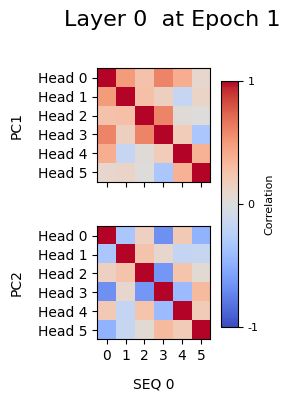

Epoch 1, MSE Loss: 2.9041, Correlation Loss: 18.0429


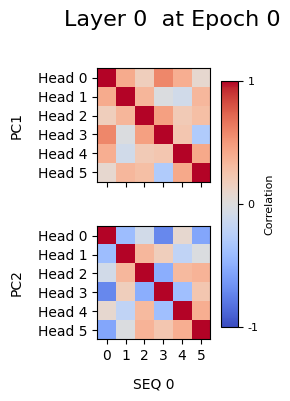

Epoch 1001, MSE Loss: 0.1055, Correlation Loss: 0.2216


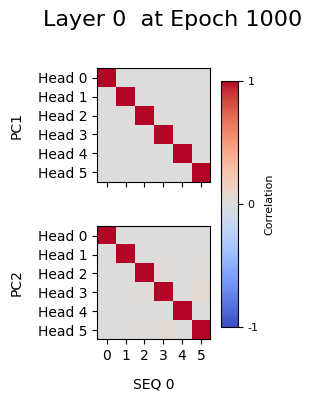

Epoch 2001, MSE Loss: 0.0033, Correlation Loss: 0.0949


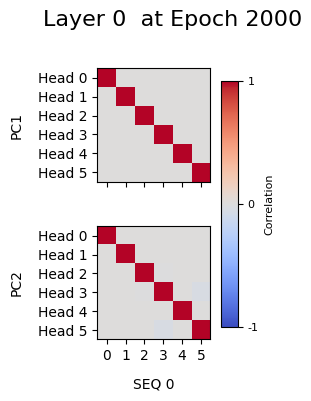

Epoch 3001, MSE Loss: 0.0035, Correlation Loss: 0.0363


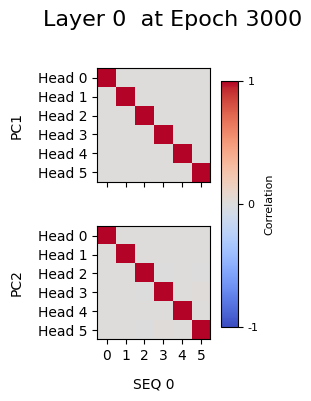

Epoch 4001, MSE Loss: 0.0065, Correlation Loss: 0.0550


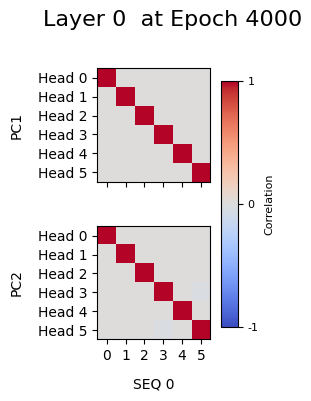

Epoch 5001, MSE Loss: 0.0007, Correlation Loss: 0.0404


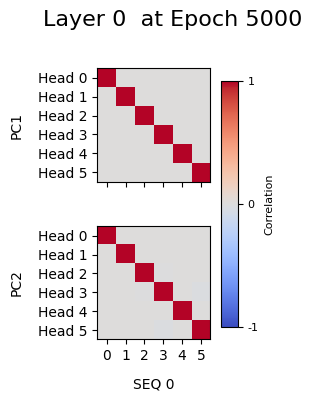

Epoch 6001, MSE Loss: 0.0030, Correlation Loss: 0.0159


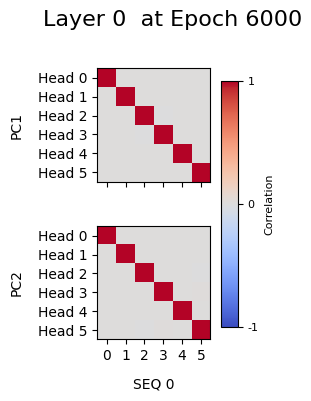

Epoch 7001, MSE Loss: 0.0004, Correlation Loss: 0.0150


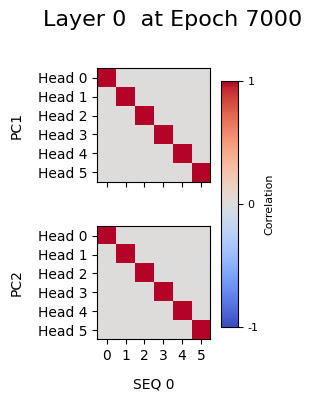

Epoch 8001, MSE Loss: 0.0033, Correlation Loss: 0.0013


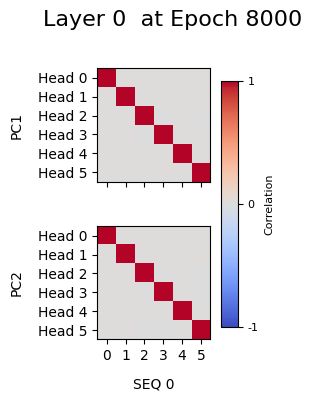

Epoch 9001, MSE Loss: 0.0034, Correlation Loss: 0.0133


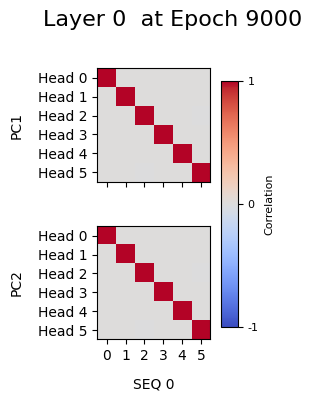

final loss tensor(0.00, grad_fn=<MseLossBackward0>)


In [469]:

# Generate synthetic data
# activations is [batch, seq, heads, d_model]
n_samples  = 1000
n_seq      = 1
n_heads    = 6
n_features = 4

X = t.rand((n_samples, n_features))
coefficients = t.tensor([ float(i) for i in range(1, n_features+1)])

Y = t.sum(coefficients * X, dim=1, keepdim=False)  + 0.01 * t.randn((n_samples))


model         = MyModel(n_features = n_features, n_heads=n_heads)
corr_loss     = CorrLoss(rank=2)

optimizer      = optim.Adam( model.parameters() , lr=0.01)#,weight_decay=0.1) produces bad results

corr_loss.plot_tensors( model(X), epoch=1)

n_samples_to_select = 100
steps               = 10000

for epoch in range(steps):

    indices = t.randperm(n_samples)[:n_samples_to_select]
    sampled_X, sampled_Y = X[indices], Y[indices]

    # batch, heads, features 
    activations   = model(sampled_X) 
    reg_loss      = corr_loss(activations)


    mse_losses    = nn.MSELoss()(   t.sum(activations, dim=(1,2,3)).squeeze() ,  sampled_Y ) 
    combined_loss = mse_losses + reg_loss 

    optimizer.zero_grad()
    combined_loss.backward()
    optimizer.step()

    if (epoch) % 1000 == 0:
        print(f"Epoch {epoch+1}, MSE Loss: {mse_losses.item():.4f}, Correlation Loss: {reg_loss.item():.4f}"
)
        corr_loss.plot_tensors(activations, epoch=epoch)

# print( t.sum( model(X), dim=(1,2,3)).shape ) 
# print( Y.shape ) 
# print("original loss", nn.MSELoss()( X.squeeze()  ,  Y ) ) 
print("final loss", nn.MSELoss()( t.sum( model(X), dim=(1,2,3)).squeeze() ,  Y ) ) 


In [413]:
x_ = t.eye(n_features)
print(x_)

# y_ = model.mlps[0](t.tensor(x_))
yf = model(x_).sum(dim=(1,2,3))
print(yf.shape)

for  i in range(len(yf)) :
    print(yf[i].item()  )

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
torch.Size([4])
1.348813533782959
1.9211900234222412
3.100928783416748
4.017218112945557


torch.Size([1000, 4])
torch.Size([1000, 1, 6, 4])
torch.Size([1000, 1, 4, 1])


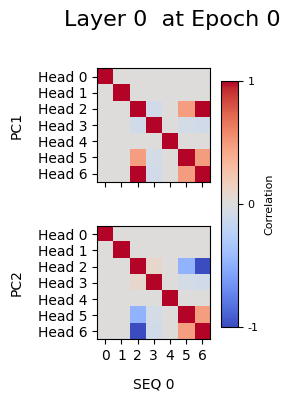

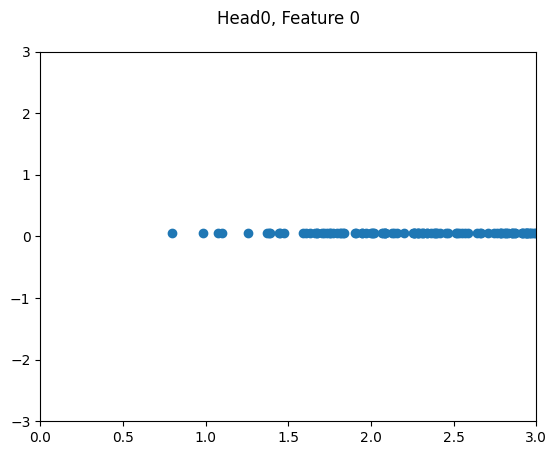

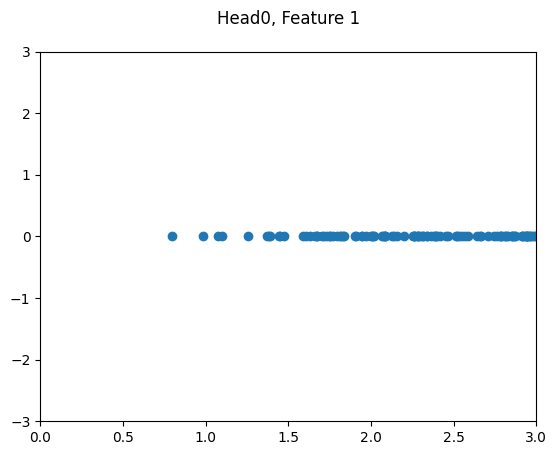

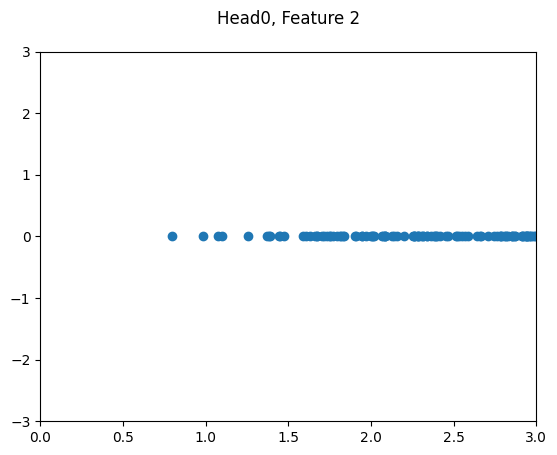

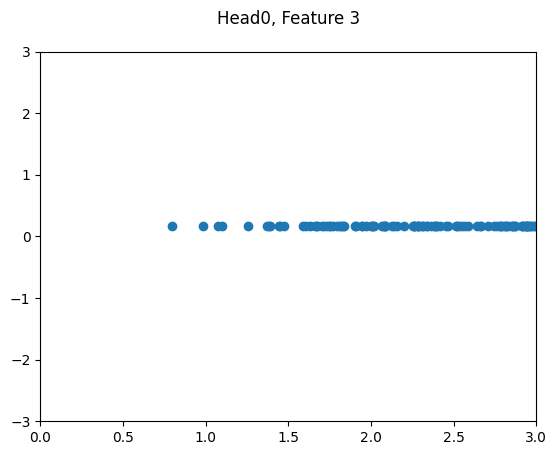

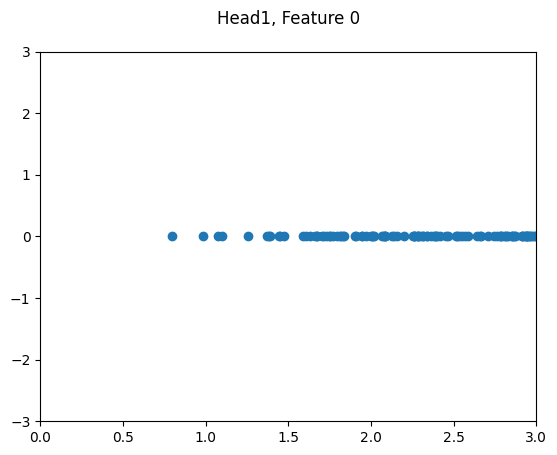

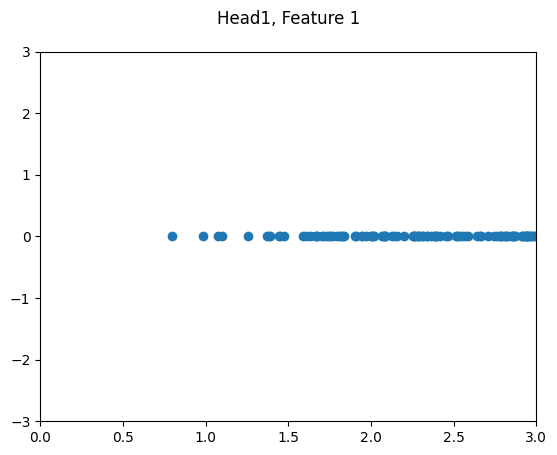

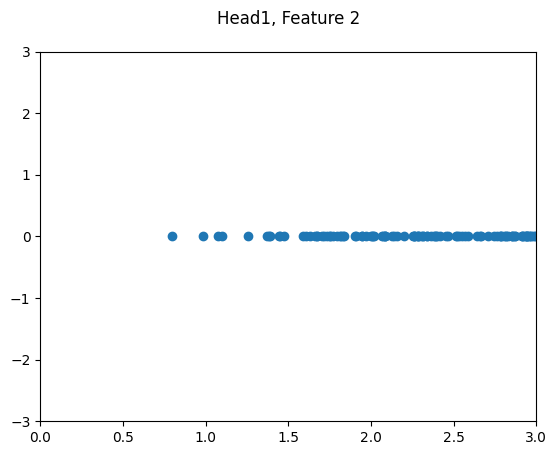

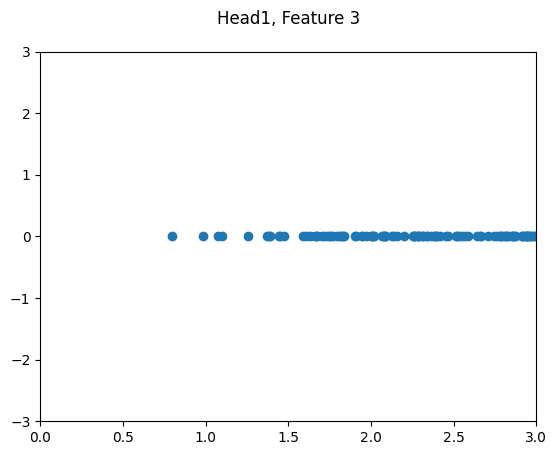

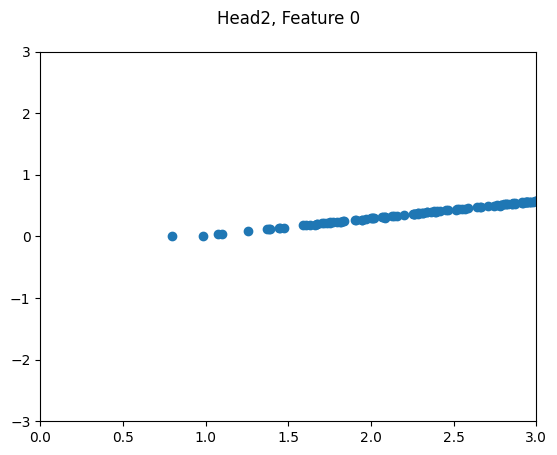

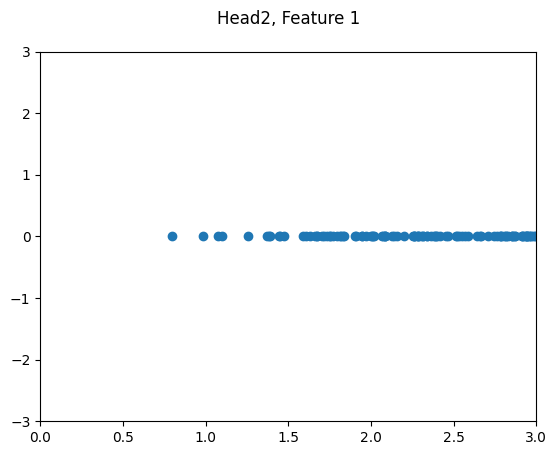

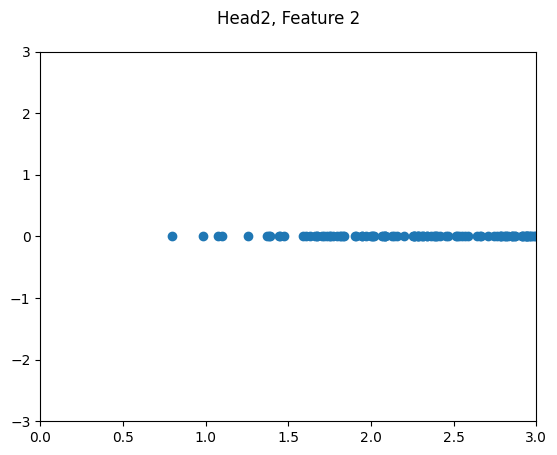

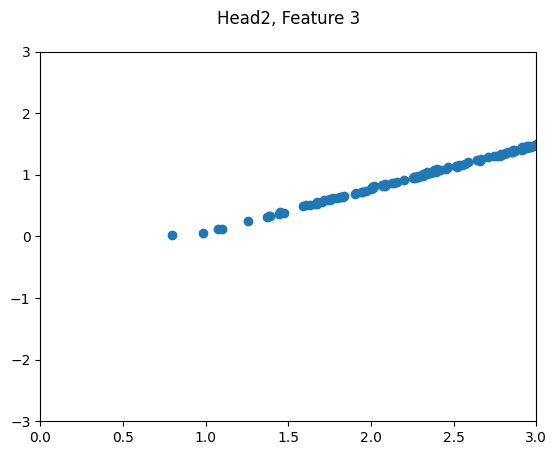

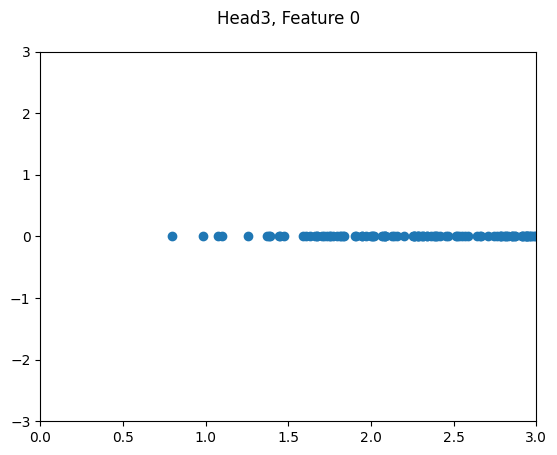

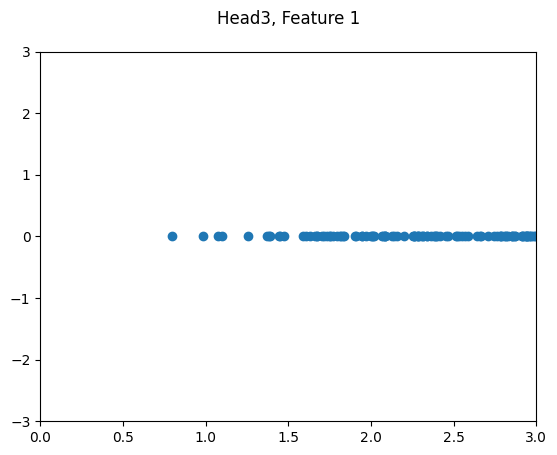

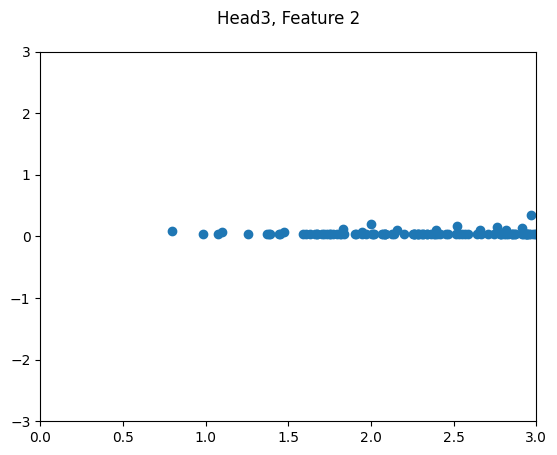

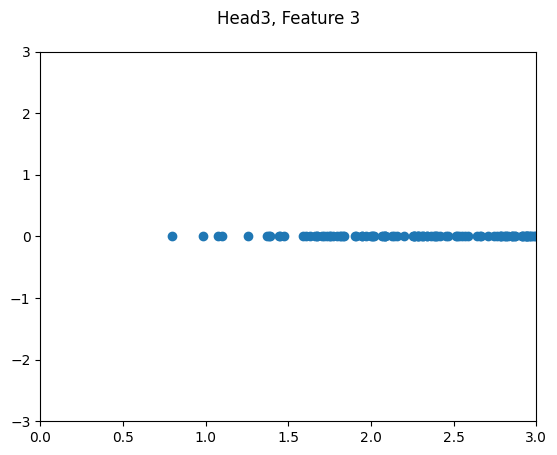

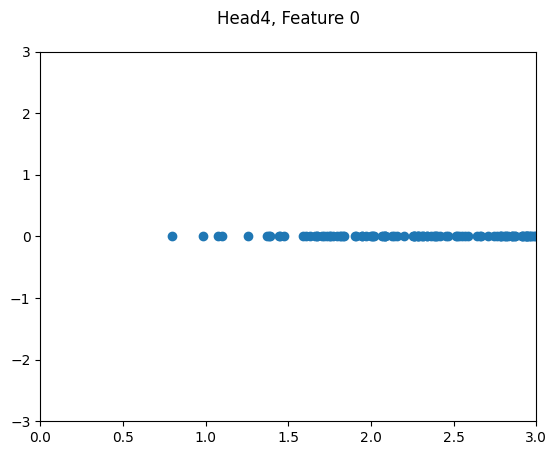

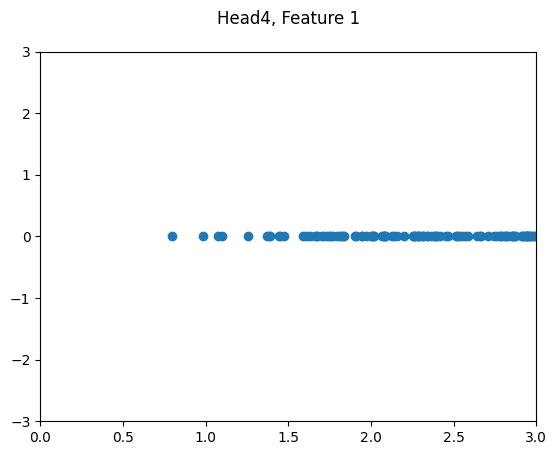

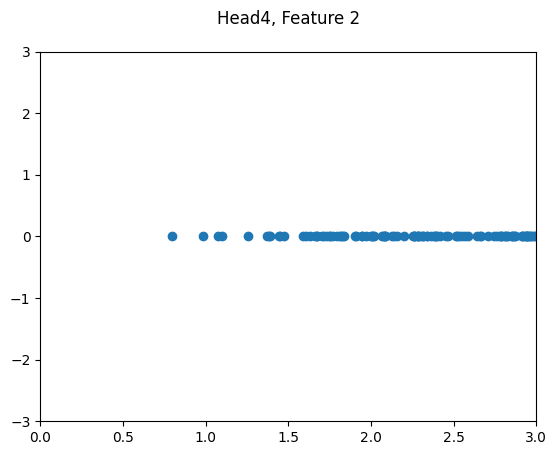

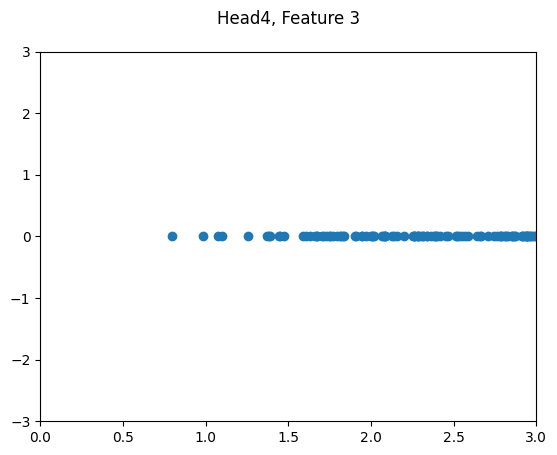

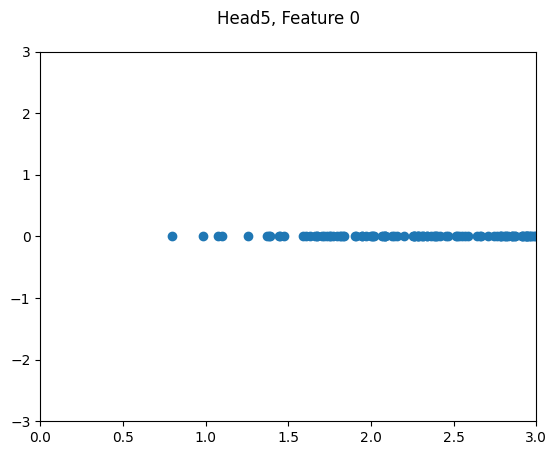

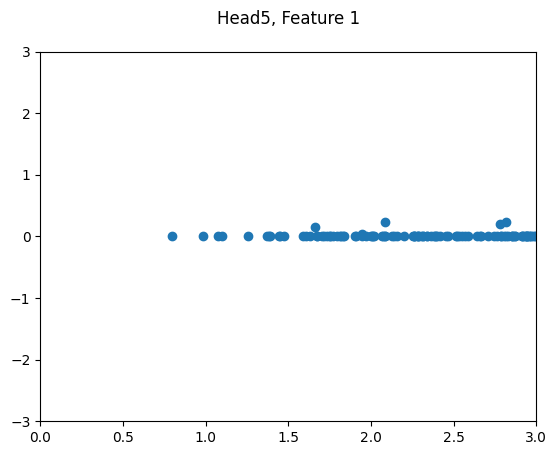

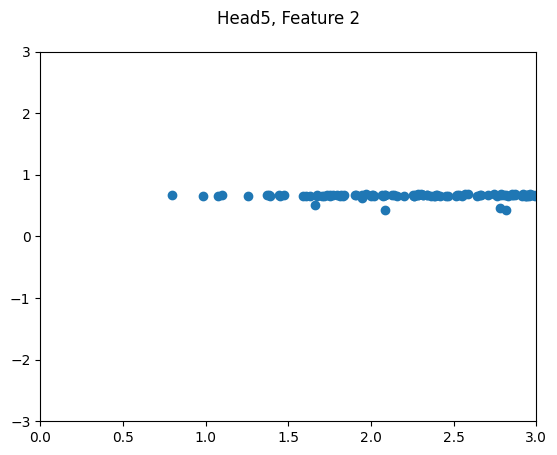

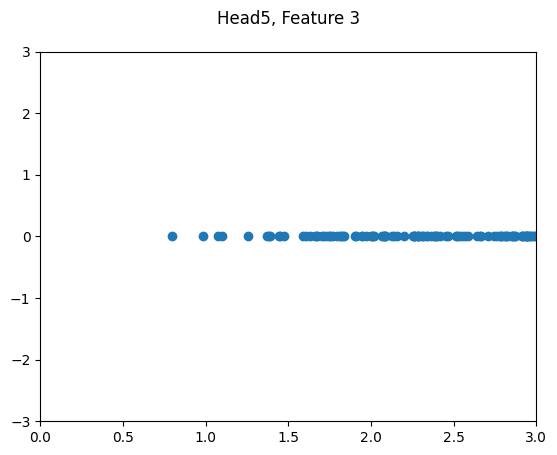

In [470]:
# x = t.tensor( [[(i-50)/100.0,(i-50)/100.0] for i in range(100) ] ).squeeze(0)
print(X.shape)
activations = model(X)
print(activations.shape)
# torch.Size([1000, 1, 6, 3])

yc = t.stack([ Y for i in range(activations.shape[-1])], dim=1).unsqueeze(1).unsqueeze(-1)
print(yc.shape)

yc = yc.reshape(yc.shape[0],yc.shape[1],yc.shape[3],yc.shape[2])

act_y = t.cat((activations, yc), dim=2)

corr_loss.plot_tensors(act_y, epoch=0)

bounds = 3


# # batch, heads, features 
for i in range(activations.shape[-2]) :
    for j in range(activations.shape[-1]) :
        plt.scatter(Y, activations[:,0,i,j].detach().cpu().numpy() )
        plt.title
        plt.xlim(0, 3)  # Set bounds for x-axis
        plt.ylim(-bounds, bounds)  # Set bounds for y-axis
        plt.title(f'Head{i}, Feature {j}', pad=20)
        plt.show()

# def print_model_weights(model):
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(f'{name} :',param.data)

# print_model_weights(model)
 
y_pred = t.sum( activations, dim=(1,2,3) )

# plot_predictions_vs_train( y_pred , Y)

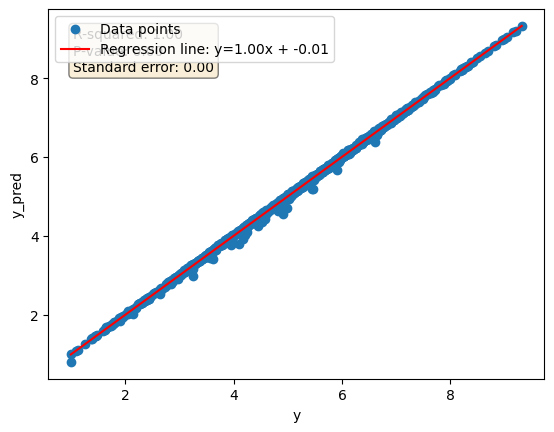

In [471]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_regression(x, y, xlabel='x', ylabel='y'):

    x = x.squeeze().detach().cpu().numpy()
    y = y.squeeze().detach().cpu().numpy()
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Scatter plot
    ax.scatter(x, y, label='Data points')

    # Regression line
    x_reg = np.linspace(x.min(), x.max(), 100)  # 100 points for a smooth line
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, color='red', label=f'Regression line: y={slope:.2f}x + {intercept:.2f}')

    # Display statistics
    text_str = f'R-squared: {r_value**2:.2f}\nP-value: {p_value:.2f}\nStandard error: {std_err:.2f}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Labels and legend
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')

    # Show plot
    plt.show()

plot_regression( y_pred, Y, xlabel='y', ylabel='y_pred')


In [418]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import r2_score
from PyALE import ale
import pandas as pd

# Create a DataFrame
features=['0', '1', '2', '3']
df = pd.DataFrame(X.detach().cpu().numpy(), columns=features)

# # Now df is a Pandas DataFrame with the data from tensor
# print(df[features])

class SKlearnModel(BaseEstimator):
    def __init__(self) :
        return

    def fit(self, X, y):
        # do nothing
        return

    def predict(self, X):
        X = t.tensor(X.to_numpy(), dtype=t.float32)
        activations = [ mlp(X) for mlp in mlps]     
        all_activations = t.stack(activations, dim=1) 
        outputs = t.sum(all_activations, dim=(1,2)).unsqueeze(1) 
        return outputs.detach().cpu().numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

# Usage:
sk_mod = SKlearnModel()

ale_eff = ale(
    X=df[features], model=sk_mod, feature=['0'], grid_size=50, include_CI=True, C=0.95
)
ale_eff = ale(
    X=df[features], model=sk_mod, feature=['1'], grid_size=50, include_CI=True, C=0.95
)
ale_eff = ale(
    X=df[features], model=sk_mod, feature=['2'], grid_size=50, include_CI=True, C=0.95
)




PyALE._ALE_generic:INFO: Continuous feature detected.


            0         1         2         3
0    0.002854  0.879583  0.408421  0.035865
1    0.089522  0.867942  0.628968  0.643242
2    0.806679  0.262586  0.011495  0.843936
3    0.487838  0.072626  0.184169  0.517022
4    0.060145  0.720817  0.935893  0.446332
..        ...       ...       ...       ...
995  0.713308  0.501554  0.476394  0.753691
996  0.492747  0.955882  0.000833  0.914090
997  0.365943  0.669677  0.788333  0.407258
998  0.472476  0.276341  0.111199  0.998320
999  0.436065  0.897283  0.553903  0.380812

[1000 rows x 4 columns]


Exception: Please check that your model is fitted, and accepts X as input.

PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.


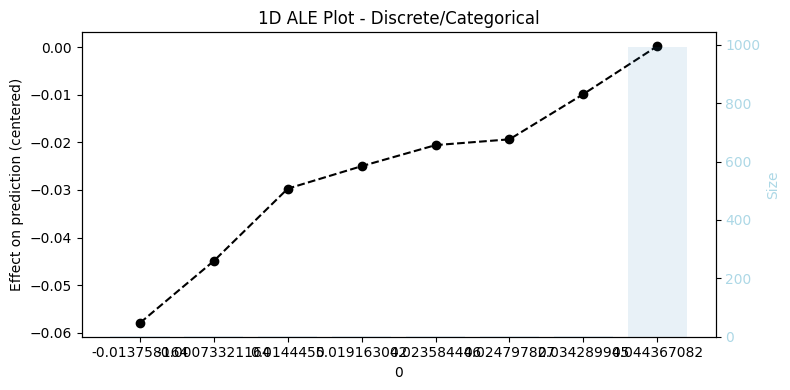

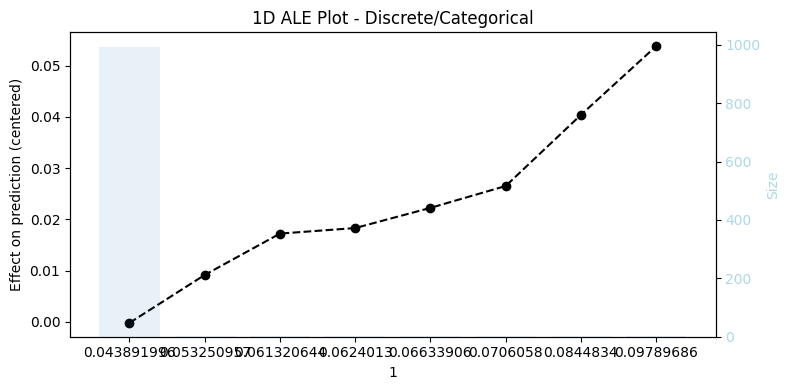

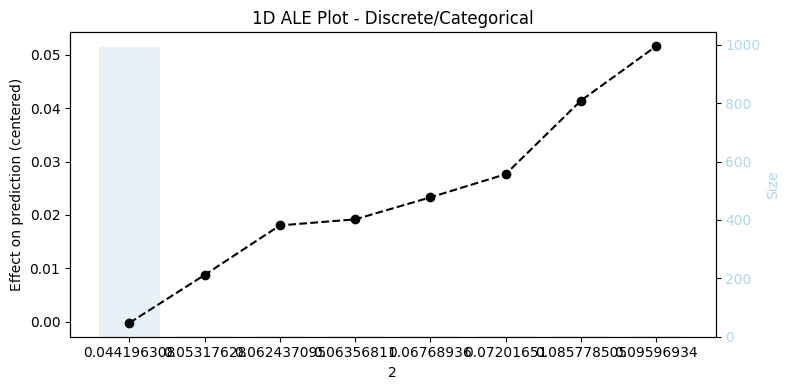

In [132]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import r2_score
from PyALE import ale
import pandas as pd


df = pd.DataFrame(all_activations[:,0,:].detach().cpu().numpy(), columns=features)

class SKlearnModel(BaseEstimator):
    def __init__(self) :
        return

    def fit(self, X, y):
        # do nothing
        return

    def predict(self, X):
        all_activations = t.tensor(X.to_numpy(), dtype=t.float32)
        outputs = t.sum(all_activations, dim=1).unsqueeze(1) 
        return outputs.detach().cpu().numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

# Usage:
sk_mod = SKlearnModel()

ale_eff0 = ale(
    X=df[features], model=sk_mod, feature=['0'], grid_size=50, include_CI=True, C=0.95
)
ale_eff1 = ale(
    X=df[features], model=sk_mod, feature=['1'], grid_size=50, include_CI=True, C=0.95
)
ale_eff2 = ale(
    X=df[features], model=sk_mod, feature=['2'], grid_size=50, include_CI=True, C=0.95
)




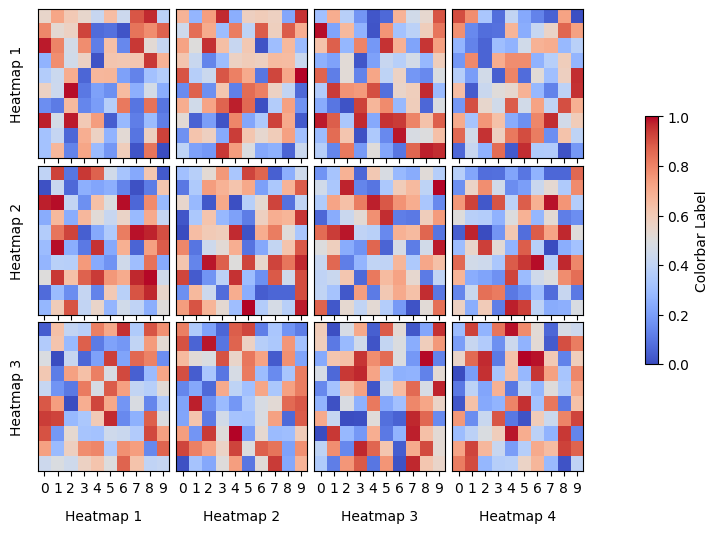

In [423]:
import matplotlib.pyplot as plt
import numpy as np





all_m      = self.all_tensors(activations)
m_list_len = len( list(itertools.chain.from_iterable(all_m)))
rows = math.ceil( m_list_len / cols )
plt.figure(figsize=(15, 3*rows))
count = 0
# loop over seq
for i, matrices in enumerate(all_m):
    # loop over features (e.g. rank)
    for j, matrix in enumerate(matrices):
        count = count + 1
        plt.subplot(rows, cols, count)
        cax = plt.matshow(matrix.detach().numpy(), cmap=plt.cm.coolwarm, vmin=-1, vmax=1, fignum=False)
        plt.colorbar(cax)
        plt.title(f'Layer{layer}, Seq{i}, Feature {j} at Epoch {epoch}', pad=20)
plt.tight_layout()
plt.show()

# returns a list for every seq [ [ [head,head], [head,head], ... ], [ [head,head], [head,head], ... ], ... ]
def plot_heatmap_grid(activations):

    assert activations.dim() == 4, "activations must be [batch, seq, heads, d_model]"

    data = self.all_tensors(activations)

    cols = len(data)
    rows = len(data[0])

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows), sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, ax in enumerate(axes.flat):
        r = i // cols
        c = i % cols

        data = data[c][r].detatch().cpu().numpy()

        im = ax.imshow( data , cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        
        if i % cols == 0:
            ax.set_yticks(range(data.shape[0]))
            ax.set_yticklabels([ f"Head {str(h)}" for h in range(data.shape[0]) ])
            ax.set_ylabel( f"PC{str(r+1)}", labelpad=10)
        else:
            ax.set_yticks([])
            
        if i // cols == rows - 1:
            ax.set_xticks(range(data.shape[1]))
            ax.set_xticklabels([ f"Head {str(h)}" for h in range(data.shape[0]) ])
            ax.set_xlabel(f"SEQ {str(c)}", labelpad=10)
        else:
            ax.set_xticks([])
        
    # Create a single colorbar
    cbar = plt.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Correlation', rotation=90)

    plt.show()

# Generate some example data
np.random.seed(0)  # For reproducibility
data = [np.random.rand(10, 10) for _ in range(12)]  # Assume 12 heatmaps
cols = 4  # 4 columns
rows = 3  # 3 rows

# Define the value range for the color scale
vmin = 0
vmax = 1

# Define labels for the outer perimeter
xlabels = [str(i) for i in range(10)]  # Assuming 10 entries along the x-axis
ylabels = [str(i) for i in range(10)]  # Assuming 10 entries along the y-axis
heatmap_labels = [f'Heatmap {i+1}' for i in range(12)]

# Call the function to plot the grid
plot_heatmap_grid(data, cols, rows, vmin, vmax, xlabels, ylabels, heatmap_labels)
